# SET UP

In [3]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'



wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Feature Engineering

In [4]:
data = pd.read_csv('preprocessed_data.csv')
hydro = data[data['ID'] == '05RE003']
hydro['Water Level_previous'] = hydro["Value"].shift(1) 
hydro['WL_pct'] = 10000*(hydro["Value"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
hydro.dropna(inplace = True)

## Statistical Features 

In [5]:
hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()

hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()

hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

hydro.dropna(inplace = True )

In [6]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6']

## Time Based Features 

In [7]:
hydro['Date'] = pd.to_datetime(hydro['Date'])
hydro['hour'] = hydro['Date'].dt.hour
hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek
hydro['month'] =  hydro['Date'].dt.month

In [8]:
cat_feat = ['hour','dayOfweek','month']

In [9]:
embbedded_size  = [(24,12),(7,4),(12,6)]

# Modling Part 

In [10]:
seq_len = len(hydro)
train_data = hydro.iloc[:int(0.8*seq_len)] 
val_data = hydro.iloc[int(0.8*seq_len):] 

## Stacked LSTM 

In [11]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Staked.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True 
)

--------- Epoch 0 ---------
 train_loss  = 1.887933488730546
 val_loss  = 1.449563002317316
--------- Epoch 10 ---------
 train_loss  = 1.3927397556029832
 val_loss  = 1.217607710758845
--------- Epoch 20 ---------
 train_loss  = 1.339960121846461
 val_loss  = 1.2363747148671085
Eraly Stopping on Epoch 22
Best Loss =  1.21611257220308


# Auto Encoder + LSTM Stacked 

In [12]:
# Hyperparameters 
train_batch_size = 128
valid_batch_size = 64
epochs = 200
input_size = len(num_feat)
hidden_size = 32
lr = 5e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Staked.pth'
verbose = False
emb_size = 8

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

autoencoder_lstm = LSTMAutoEncoder(input_size = input_size ,hidden_size = hidden_size,emb_size= emb_size )
autoencoder_lstm = autoencoder_lstm.to(device)

val_loss, train_loss = run(
    autoencoder_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose , 
    is_forcaster = True , 
    is_added_auto_encoder = True,
)

--------- Epoch 0 ---------
 train_loss  = 2.4547710885172305
 val_loss  = 1.9374057579299677
--------- Epoch 10 ---------
 train_loss  = 2.206121750499891
 val_loss  = 1.8112206096234529
--------- Epoch 20 ---------
 train_loss  = 1.6752719049868376
 val_loss  = 1.639737011945766
--------- Epoch 30 ---------
 train_loss  = 1.5935259279997454
 val_loss  = 1.580118249291959
Eraly Stopping on Epoch 30
Best Loss =  1.5513699637806935


## Evaluation 

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
val_data = val_data.iloc[window_size:]

pred = predict( stacked_lstm , valid_dataset)
val_data['WL_pct_hat'] = pred / 10000
val_data['WL_hat_stacked_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )

pred = predict( autoencoder_lstm , valid_dataset ,is_added_auto_encoder = True )
val_data['WL_pct_hat'] = pred / 10000
val_data['WL_hat_autoencoder_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )

fig = make_subplots()
fig.add_trace(go.Scatter( y=val_data['Value'].values, name='Ground Truth values'))
fig.add_trace(go.Scatter( y=val_data['WL_hat_stacked_lstm'].values ,name='stacked_lstm predictions'))
fig.add_trace(go.Scatter( y=val_data['WL_hat_autoencoder_lstm'].values ,name='LSTM + AutoEncoder  predictions'))

fig.show()

100%|██████████| 23/23 [00:00<00:00, 62.65it/s]


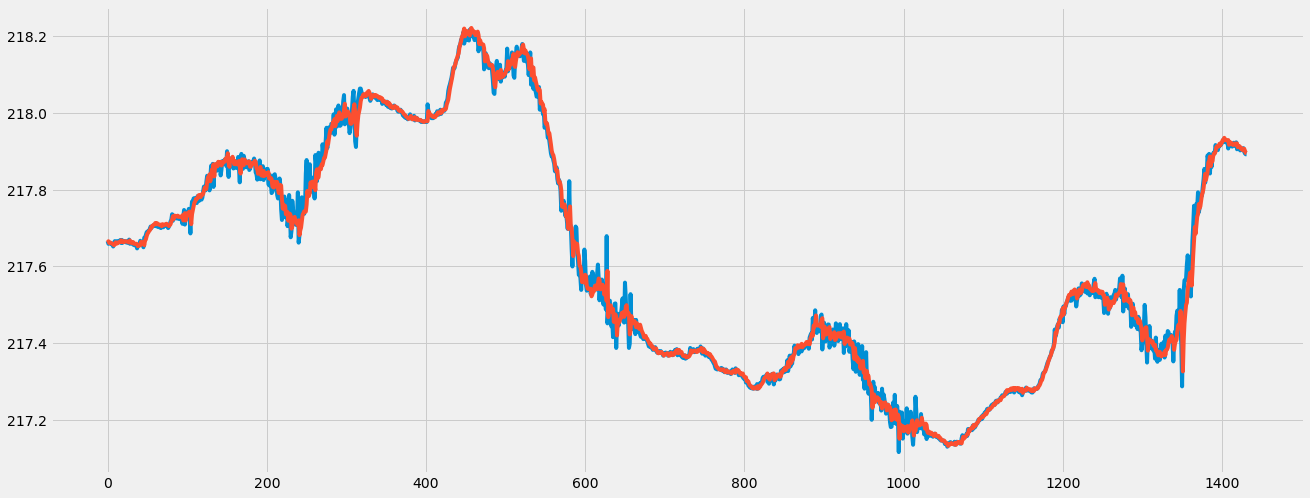

In [15]:
plt.plot( val_data['Value'].values, label='Ground Truth values')
plt.plot( val_data['WL_hat_stacked_lstm'].values ,label='stacked_lstm predictions')
plt.show()

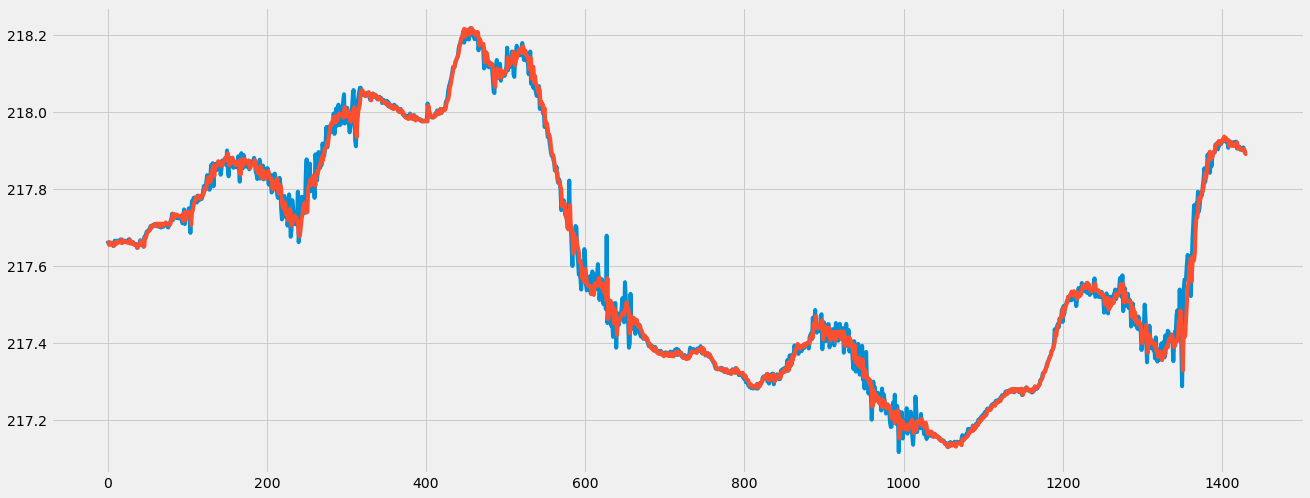

In [16]:
plt.plot( val_data['Value'].values, label='Ground Truth values')
plt.plot( val_data['WL_hat_autoencoder_lstm'].values ,label=' LSTM + AutoEncoder predictions ')
plt.show()

In [17]:
print('LSTM Stacked Model Results')
print('MSE = ' , mean_squared_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data['Value'], val_data['WL_hat_stacked_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))
print('mean_absolute_percentage_error = ', mean_absolute_percentage_error(val_data['Value'], val_data['WL_hat_stacked_lstm']))

LSTM Stacked Model Results
MSE =  0.0005789963296934627
RMSE =  0.024062342564543933
mean_absolute_error =  0.015015791428364086
mean_absolute_percentage_error =  0.006899670428378982


In [18]:
print('LSTM + AutoEncoder Model Results')
print('MSE = ' , mean_squared_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))
print('RMSE = ', math.sqrt(mean_squared_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm'])))
print('mean_absolute_error = ', mean_absolute_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))
print('mean_absolute_percentage_error = ', mean_absolute_percentage_error(val_data['Value'], val_data['WL_hat_autoencoder_lstm']))

LSTM + AutoEncoder Model Results
MSE =  0.0006017081741109966
RMSE =  0.024529740604233803
mean_absolute_error =  0.01509935819952841
mean_absolute_percentage_error =  0.006938289578035718
